In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import chi2_contingency
from statsmodels.stats.proportion import proportions_ztest


In [2]:
df_original = pd.read_csv('final.csv')

cols = ['client_id','visit_id','process_step','date_time','variation_cleaned','client_tenure_year','client_tenure_month','client_age','gender_cleaned','number_of_accounts','calls_6_month','logos_6_month']
df_original = df_original[cols]
df_original.rename(columns={'process_step':'step','variation_cleaned':'variation','client_tenure_year':'tenureYear','client_tenure_month':'tenureMonth','gender_cleaned':'gender','client_age':'age'
                            },inplace=True)

df_original['date_time'] = pd.to_datetime(df_original['date_time'])

df_original.shape

(744641, 12)

##### create id 

In [3]:
df_original['id'] = df_original['client_id'].astype('str') + '__' + df_original['visit_id'].astype('str')

##### age distribution + create age group

/var/folders/zd/t_pj2nzd2_x4z46k814jg73r0000gn/T/ipykernel_1214/3295496339.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(unique_clients[unique_clients['age']>0]['age'],bins=20,palette="Blues" )


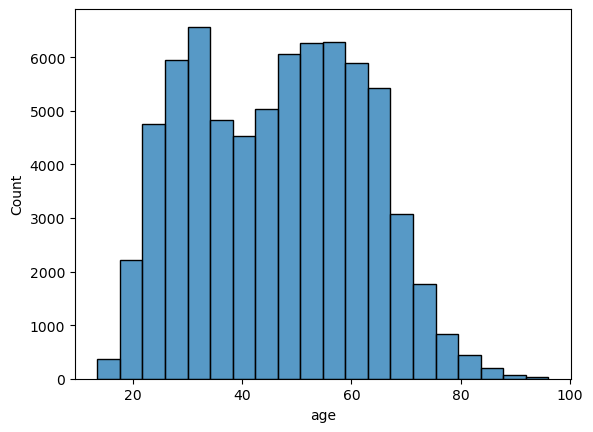

In [4]:
unique_clients = df_original.drop_duplicates(subset="client_id")
sns.histplot(unique_clients[unique_clients['age']>0]['age'],bins=20,palette="Blues" )
plt.show()

age_bins =[0,25,35,50,65,80,np.inf]
age_labels = ["<25", "25-35", "36-45", "46-65", "66-80", "80+"]
df_original['age_group']= pd.cut(df_original['age'].replace(-1,np.nan),bins=age_bins,labels=age_labels,right=True).cat.add_categories('unknown').fillna('unknown')




##### create tenure year group

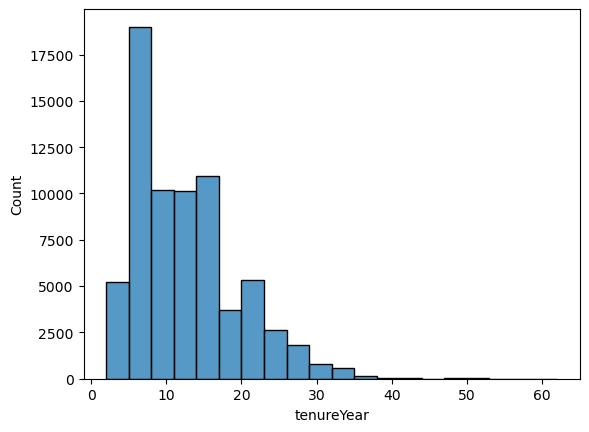

In [5]:
unique_clients = df_original.drop_duplicates(subset="client_id")
sns.histplot(unique_clients[unique_clients['tenureYear']>0]['tenureYear'],bins=20 )
plt.show()


df_original["tenureYear_group"] = pd.cut(
    df_original["tenureYear"].replace(-1, np.nan),
    bins=[0, 5, 10,15, 20, float("inf")],
    labels=["New (<5y)", "Mid-New(5-10y)","Mid (10-15y)","Mid-Long(15-20y)" ,"Long (>20y)"],
    right=False
).cat.add_categories("Unknown").fillna("Unknown")



In [27]:
unique_clients.to_csv('unique_clients.csv')

#### EDA ----- Are the primary clients new or long-standing? 

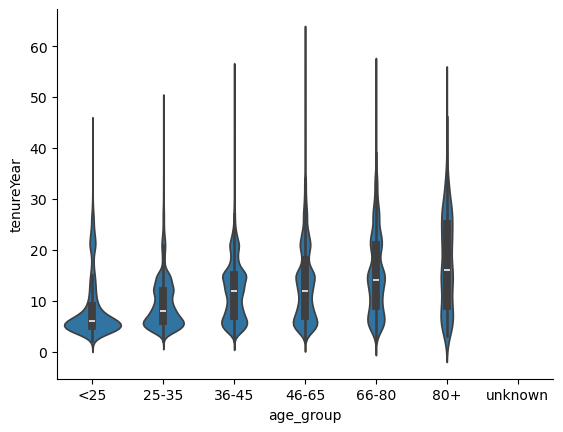

In [6]:
# voilin plot
unique_clients = df_original.drop_duplicates(subset="client_id")

sns.violinplot(data=unique_clients[
                                     (unique_clients['tenureYear'] >= 0)
                                     ], x='age_group', y='tenureYear')
sns.despine()
plt.show()

In [7]:
unique_clients.tenureYear.dtype
unique_clients['tenureYear'].describe()

count    120157.000000
mean          6.668908
std           8.308661
min          -1.000000
25%          -1.000000
50%           5.000000
75%          12.000000
max          62.000000
Name: tenureYear, dtype: float64

#### EDA --- age distribution in test and control

1. The shapes of the curves are very similar, we can tell from the graph that test and Control are balanced in age distribution


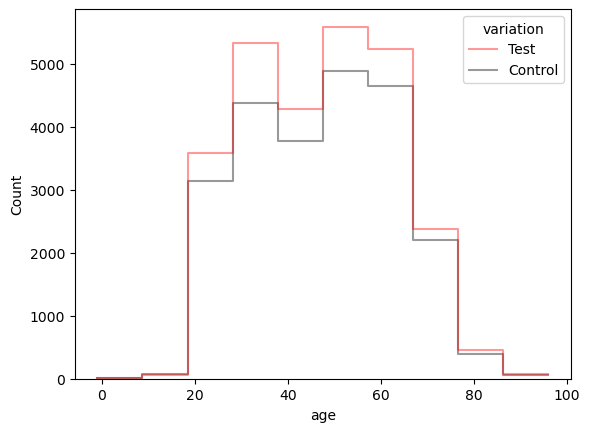

In [8]:

sns.histplot(x = 'age',
             hue = 'variation',
             data=unique_clients[~(unique_clients['variation']=='unknown')],
             
                 # shaded KDE
    alpha=0.4,
     bins=10,
            fill=False, 
            # adjust number of bins
    element='step',       # outline instead of filled bars
    stat='count',         # or 'density' if you want normalized
    common_norm=False,    # keeps group scaling separate
    multiple='layer',
    palette={'Control': 'black', 'Test': 'red'})
plt.show()


#### EDA - tenure year distribution in test and control
1. The shapes are nearly identical

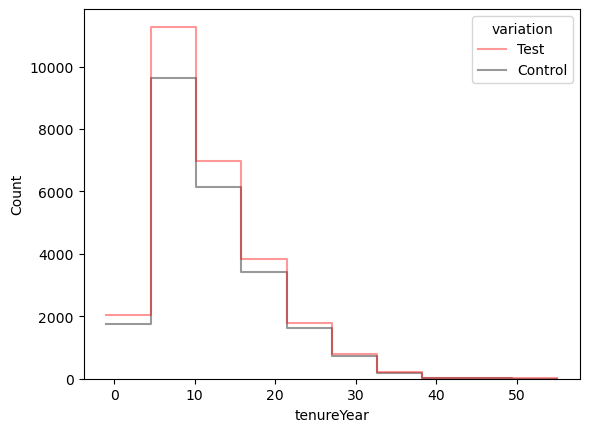

In [9]:
sns.histplot(x = 'tenureYear',
             hue = 'variation',
             data=unique_clients[~(unique_clients['variation']=='unknown')],
             
                 # shaded KDE
    alpha=0.4,
     bins=10,
            fill=False, 
            # adjust number of bins
    element='step',       # outline instead of filled bars
    stat='count',         # or 'density' if you want normalized
    common_norm=False,    # keeps group scaling separate
    multiple='layer',
    palette={'Control': 'black', 'Test': 'red'})
plt.show()

#### EDA - gender distribution in test and control
1. we can see from the graph that gender distribution is well balanced in test/control

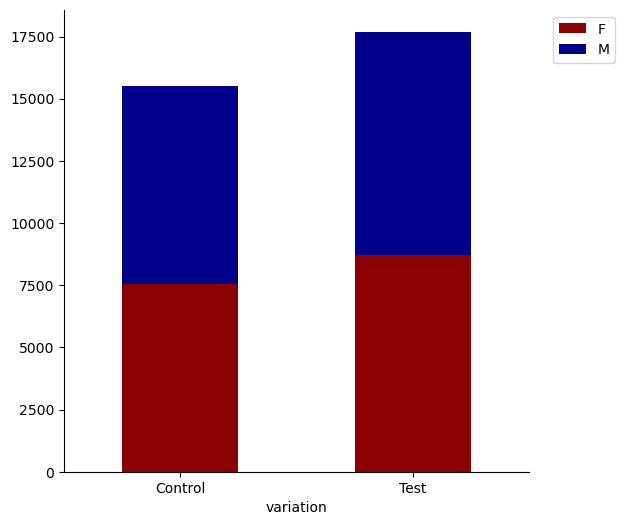

In [10]:

pivot = unique_clients[~((unique_clients['gender']=='unknown')|(unique_clients['variation']=='unknown'))].pivot_table(index='variation',columns='gender',aggfunc='count',values='client_id')

pivot.plot(kind='bar',
           stacked=True,
           figsize=(6,6),
           color=["darkred", "darkblue"],
           width = 0.5)
plt.legend(loc ='upper right',bbox_to_anchor=(1.2, 1))
sns.despine()
plt.xticks(rotation = 0)
plt.show()

In [11]:
df_original.shape
df_original.to_csv('Vanguard.csv')

#### KPI - completion rate

In [12]:
# define a function to calculate confirmation rate 
def confirmation_rate (df):
    confirmed = df[df['step']=='confirm']
    numerator = confirmed['id'].nunique()
    denominator = df['id'].nunique()
    return numerator,denominator,numerator/denominator

df_original = df_original.copy()
df_test = df_original[df_original['variation'] == 'Test' ]
df_control = df_original[df_original['variation'] == 'Control' ]


c_rate_control = confirmation_rate(df_control)[2]
print(f"confirmation rate for control group is {c_rate_control}")
c_rate_test = confirmation_rate(df_test)[2]
print(f"confirmation rate for test group is {c_rate_test}")

completion_dic = {'Group':['test','control'],'Completion_Rate':[c_rate_test,c_rate_control]}
completion_dic
completion_df = pd.DataFrame(completion_dic)
completion_df.to_csv('completion_df.csv')

confirmation rate for control group is 0.49896101479390875
confirmation rate for test group is 0.58571658961402


#### KPI - Time Spent on Each Step: The average duration users spend on each step.

In [13]:
def calculate_duration(df):
    df = df.copy()
    df['step_number'] = df['step'].map({'start':1,'step_1':2,'step_2':3,'step_3':4,'confirm':5})
    df.sort_values(by=['id','date_time'],ascending=True,inplace=True)
    df['duration'] = df.groupby('id')['date_time'].shift(-1) - df['date_time']
    df['duration'] = df['duration'].dt.total_seconds()
    return df

df_original = calculate_duration(df_original)
df_original.shape


(744641, 17)

In [14]:
# check if there is duration < 0 
(df_original['duration']<0).sum()


np.int64(0)

In [15]:
# check if there is outliers in duration, 
print(df_original['duration'].describe())

IQR_duration = df_original['duration'].quantile(0.75) - df_original['duration'].quantile(0.25)
lower = df_original['duration'].quantile(0.25) - 1.5*IQR_duration
high = df_original['duration'].quantile(0.75) + 1.5*IQR_duration  # 185

# remove duration higher than 185, it might skew average 

df = df_original.copy()
df = df_original[df_original['duration']<= 185]


count    585529.000000
mean         85.057854
std         209.920169
min           0.000000
25%          13.000000
50%          35.000000
75%          82.000000
max       40235.000000
Name: duration, dtype: float64


In [16]:
# calculation for test group
test = df[df['variation'] == 'Test'].groupby(['id','step'])['duration'].agg('sum').reset_index().groupby(['step'])['duration'].agg(['mean'])

# calculation for test group
control = df[df['variation'] == 'Control'].groupby(['id','step'])['duration'].agg('sum').reset_index().groupby(['step'])['duration'].agg(['mean'])

result = pd.concat(
    [test.add_prefix('Test_'), control.add_prefix('Control_')], axis=1
)

result.rename(columns={'Test_mean':'Test','Control_mean':'Control'},inplace=True)

result.reset_index(inplace=True)

result


,step,Test,Control
0,confirm,85.205575,60.505560
1,start,41.942011,40.588340
2,step_1,47.785313,38.224295
3,step_2,77.953449,82.489924
4,step_3,65.924917,80.537684


In [17]:


result.melt(id_vars=['step'],var_name='Variation',value_name='Average_time_eachStep').to_csv('timeSpent.csv')

#### KPI - Error Rates: If there's a step where users go back to a previous step, it may indicate confusion or an error. You should consider moving from a later step to an earlier one as an error.

In [18]:
df_original.head(5)

,client_id,visit_id,step,date_time,variation,tenureYear,tenureMonth,age,gender,number_of_accounts,calls_6_month,logos_6_month,id,age_group,tenureYear_group,step_number,duration
89556,1000062,68804396_74737424429_397490,start,2017-04-06 15:38:49,Control,15.0,188.0,52.5,F,2.0,0.0,3.0,1000062__68804396_74737424429_397490,46-65,Mid-Long(15-20y),1,182.0
89555,1000062,68804396_74737424429_397490,step_1,2017-04-06 15:41:51,Control,15.0,188.0,52.5,F,2.0,0.0,3.0,1000062__68804396_74737424429_397490,46-65,Mid-Long(15-20y),2,10.0
89554,1000062,68804396_74737424429_397490,step_2,2017-04-06 15:42:01,Control,15.0,188.0,52.5,F,2.0,0.0,3.0,1000062__68804396_74737424429_397490,46-65,Mid-Long(15-20y),3,49.0
89553,1000062,68804396_74737424429_397490,step_3,2017-04-06 15:42:50,Control,15.0,188.0,52.5,F,2.0,0.0,3.0,1000062__68804396_74737424429_397490,46-65,Mid-Long(15-20y),4,719.0
89551,1000062,68804396_74737424429_397490,confirm,2017-04-06 15:54:49,Control,15.0,188.0,52.5,F,2.0,0.0,3.0,1000062__68804396_74737424429_397490,46-65,Mid-Long(15-20y),5,NaN


In [19]:
df_original['step_check'] = df_original.groupby('id')['step_number'].diff()
df_original['error'] = df_original['step_check'].apply(lambda x: 1 if x <0 else 0 )

df_original

,client_id,visit_id,step,date_time,variation,tenureYear,tenureMonth,age,gender,number_of_accounts,calls_6_month,logos_6_month,id,age_group,tenureYear_group,step_number,duration,step_check,error
89556,1000062,68804396_74737424429_397490,start,2017-04-06 15:38:49,Control,15.0,188.0,52.5,F,2.0,0.0,3.0,1000062__68804396_74737424429_397490,46-65,Mid-Long(15-20y),1,182.0,NaN,0
89555,1000062,68804396_74737424429_397490,step_1,2017-04-06 15:41:51,Control,15.0,188.0,52.5,F,2.0,0.0,3.0,1000062__68804396_74737424429_397490,46-65,Mid-Long(15-20y),2,10.0,1.0,0
89554,1000062,68804396_74737424429_397490,step_2,2017-04-06 15:42:01,Control,15.0,188.0,52.5,F,2.0,0.0,3.0,1000062__68804396_74737424429_397490,46-65,Mid-Long(15-20y),3,49.0,1.0,0
89553,1000062,68804396_74737424429_397490,step_3,2017-04-06 15:42:50,Control,15.0,188.0,52.5,F,2.0,0.0,3.0,1000062__68804396_74737424429_397490,46-65,Mid-Long(15-20y),4,719.0,1.0,0
89551,1000062,68804396_74737424429_397490,confirm,2017-04-06 15:54:49,Control,15.0,188.0,52.5,F,2.0,0.0,3.0,1000062__68804396_74737424429_397490,46-65,Mid-Long(15-20y),5,NaN,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
640076,9999875,931268933_219402947_599432,step_1,2017-06-01 22:40:08,unknown,-1.0,-1.0,-1.0,unknown,-1.0,-1.0,-1.0,9999875__931268933_219402947_599432,unknown,Unknown,2,80.0,1.0,0
640075,9999875,931268933_219402947_599432,step_1,2017-06-01 22:41:28,unknown,-1.0,-1.0,-1.0,unknown,-1.0,-1.0,-1.0,9999875__931268933_219402947_599432,unknown,Unknown,2,19.0,0.0,0
640074,9999875,931268933_219402947_599432,step_2,2017-06-01 22:41:47,unknown,-1.0,-1.0,-1.0,unknown,-1.0,-1.0,-1.0,9999875__931268933_219402947_599432,unknown,Unknown,3,191.0,1.0,0
640073,9999875,931268933_219402947_599432,step_3,2017-06-01 22:44:58,unknown,-1.0,-1.0,-1.0,unknown,-1.0,-1.0,-1.0,9999875__931268933_219402947_599432,unknown,Unknown,4,221.0,1.0,0


In [20]:
totalError_test = df_original[df_original['variation'] =='Test'].groupby('id')['error'].agg('sum').reset_index(name='sum')
test_errorRate = len(totalError_test[totalError_test['sum']>=1])/len(totalError_test)

totalError_control = df_original[df_original['variation'] =='Control'].groupby('id')['error'].agg('sum').reset_index(name='sum')
control_errorRate = len(totalError_control[totalError_control['sum']>=1])/len(totalError_control)

print(f"Error rate in test group is {test_errorRate}")
print(f"Error rate in Control group is {control_errorRate}")

errorRate_dic = {'Variation':['test','control'],'Error_Rate':[test_errorRate,control_errorRate]}
errorRate_df = pd.DataFrame(errorRate_dic)
errorRate_df.to_csv('Error_Rate.csv')

Error rate in test group is 0.2679550585958499
Error rate in Control group is 0.20227646310827158


#### Hypothesis Testing - age & test/control

In [21]:
# step1: Hypothesis 
    # H0: age distribution is the same across test/control (independent)
    # H1: age distribution is not the same across test/control (dependent)

# step2: set significance level = 5%, if null is true, i accept 5% probablity that I incorrectly reject true null

# step3: perform chi-square test
data=unique_clients[~(unique_clients['variation']=='unknown')]
cross_age_variation = pd.crosstab(index=data['variation'],columns=data['age_group'],normalize=False)
display(cross_age_variation)

res_age = chi2_contingency(cross_age_variation)

print(f"chi-square statistics is {res_age.statistic:.2f}")
print(f"chi-square P-value is {res_age.pvalue:.2f}, fail to reject null, so age distribution is the same across test/control.")
print(f"\nImportant TakeAway:\ntest and control are balanced in client age,so age is unlikely to bias later A/B testing results.")

age_group,<25,25-35,36-45,46-65,66-80,80+,unknown
variation,,,,,,,
Control,1754,4817,6061,7582,3080,233,5
Test,2045,5712,6968,8566,3400,270,7


chi-square statistics is 6.57
chi-square P-value is 0.36, fail to reject null, so age distribution is the same across test/control.

Important TakeAway:
test and control are balanced in client age,so age is unlikely to bias later A/B testing results.


#### Hypothesis Testing - gender & test/control

In [22]:
# step1: Hypothesis 
    # H0: gender distribution is the same across test/control (independent)
    # H1: gender distribution is not the same across test/control (dependent)

# step2: set significance level = 5%, if null is true, i accept 5% probablity that I incorrectly reject true null

# step3: perform chi-square test
pivot = unique_clients[~((unique_clients['gender']=='unknown')|(unique_clients['variation']=='unknown'))].pivot_table(index='variation',columns='gender',aggfunc='count',values='client_id')
display(pivot)
res_gender = chi2_contingency(pivot)


print(f"chi-square statistics is {res_gender.statistic:.2f}")
print(f"chi-square P-value is {res_gender.pvalue:.2f},fail to reject null,so gender distribution is the same across test and control.")
print(f"\nImportant TakeAway: \ntest and control are balanced in client gender,so gender is unlikely to bias later A/B testing results.")


gender,F,M
variation,,
Control,7543,7970
Test,8716,8977


chi-square statistics is 1.32
chi-square P-value is 0.25,fail to reject null,so gender distribution is the same across test and control.

Important TakeAway: 
test and control are balanced in client gender,so gender is unlikely to bias later A/B testing results.


#### Hypothesis Testing - tenure year & test/control

In [23]:

# step1: Hypothesis 
    # H0: tenure year distribution is the same across test/control (independent)
    # H1: tenure year distribution is not the same across test/control (dependent)

# step2: set significance level = 5%, if null is true, i accept 5% probablity that I incorrectly reject true null

# step3: perform chi-square test
data=unique_clients[~(unique_clients['variation']=='unknown')]

cross_tenureYear_variation = pd.crosstab(index=data['variation'],columns=data['tenureYear_group'],normalize=False)
display(cross_tenureYear_variation)
res_tenureyear = chi2_contingency(cross_tenureYear_variation)


print(f"chi-square statistics is {res_tenureyear.statistic:.2f}")
print(f"chi-square P-value is {res_tenureyear.pvalue:.2f},fail to reject null,so tenure year distribution is the same across test and control.")
print(f"\nImportant TakeAway: \ntest and control are balanced in client tenure year,so tenure year is unlikely to bias later A/B testing results.")


tenureYear_group,New (<5y),Mid-New(5-10y),Mid (10-15y),Mid-Long(15-20y),Long (>20y),Unknown
variation,,,,,,
Control,1746,8713,5564,3685,3819,5
Test,2033,10156,6324,4190,4258,7


chi-square statistics is 3.55
chi-square P-value is 0.62,fail to reject null,so tenure year distribution is the same across test and control.

Important TakeAway: 
test and control are balanced in client tenure year,so tenure year is unlikely to bias later A/B testing results.


#### Hypothesis Testing - completion rate

In [24]:
# H0​:p_test ​= p_control​ 
# H1:p_test​ != p_control​  

# samller , alternative : p_test < p_control
# larger, alternative : p_test > p_control  xx

# 1-sided: larger-> 16088>21791, smaller:16088<21791

count = np.array([21791, 16088])  # [test confirm, control confirm]  
nobs = np.array([37204, 32243])  # [test total, control total] 

z_stat, pvalue = proportions_ztest(count, nobs,alternative='larger')

display(z_stat,pvalue)

print(f"takeaway: p_test > p_control is significant")

np.float64(22.898861451311227)

np.float64(2.3845706650526982e-116)

takeaway: p_test > p_control is significant


#### Hypothesis Testing - completion rate with cost consideration

In [25]:

# H0​:p_test - p_control = 5%
# H1:p_test​ - p_control​  != 5%

# samller , alternative : p_test​ - p_control < 5%
# larger, alternative :  p_test​ - p_control > 5%


count = np.array([21791, 16088])  # [test confirm, control confirm]  
nobs = np.array([37204, 32243])  # [test total, control total] 

z_stat, pvalue = proportions_ztest(count, nobs,value= 0.05, alternative='larger')

display(z_stat,pvalue)

print(f"takeaway:  p_test​ - p_control > 5% is significant, so the improvement rate is higher than 5%")

np.float64(9.701518514680174)

np.float64(1.4852216195365263e-22)

takeaway:  p_test​ - p_control > 5% is significant, so the improvement rate is higher than 5%
